In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.optimize import minimize
from scipy import integrate

In [2]:
gfr_data = pd.read_csv('gfr.csv')

In [3]:
freqs, bins = np.histogram(gfr_data, bins=20)

<BarContainer object of 20 artists>

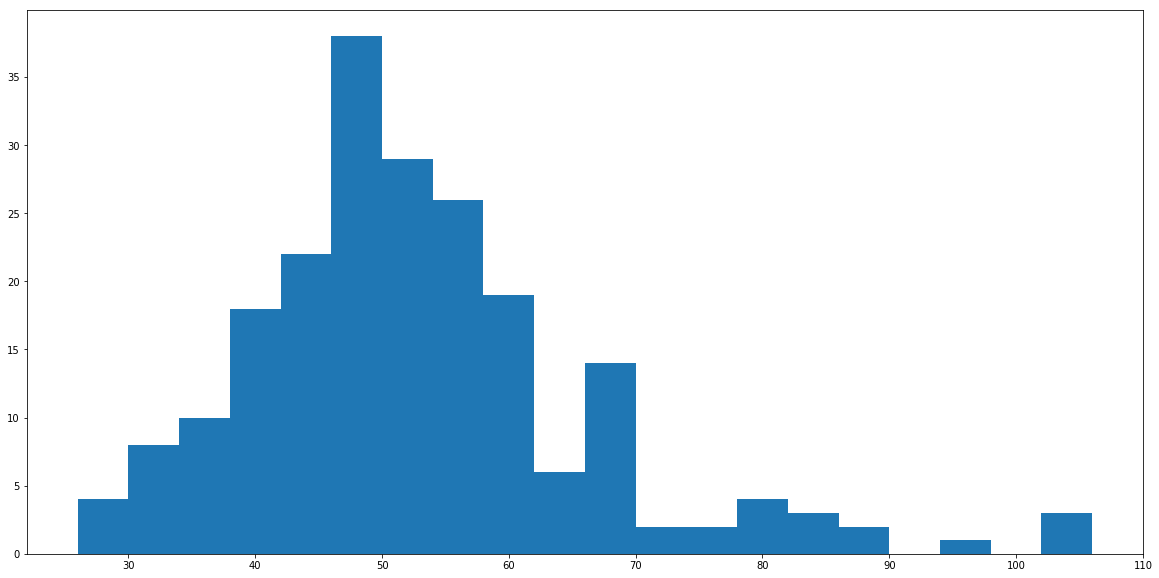

In [4]:
plt.figure(figsize=(20,10))
plt.bar(bins[:-1], freqs, width=4)

In [5]:
data_median = gfr_data.median()[0]
gfr_data['gfr'] = gfr_data['gfr'] / (data_median)
bins = bins / (data_median)

<BarContainer object of 20 artists>

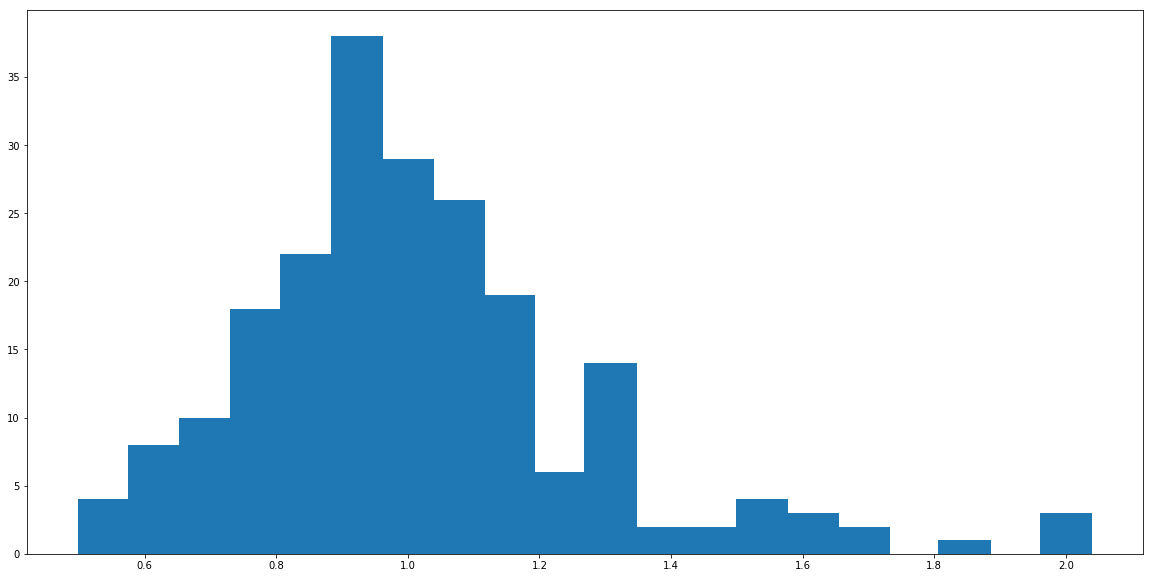

In [6]:
plt.figure(figsize=(20,10))
plt.bar(bins[:-1], freqs, width=0.08)

In [7]:
gfr_data['gfr_2'] = gfr_data['gfr'] ** 2
gfr_data['gfr_3'] = gfr_data['gfr'] ** 3
gfr_data['gfr_4'] = gfr_data['gfr'] ** 4
gfr_data['gfr_5'] = gfr_data['gfr'] ** 5
gfr_data['gfr_6'] = gfr_data['gfr'] ** 6
gfr_data['gfr_7'] = gfr_data['gfr'] ** 7

In [8]:
n = len(gfr_data['gfr'])
suff_stats = np.array([gfr_data['gfr'].mean(), 
                       (gfr_data['gfr_2']).mean() ,
                       (gfr_data['gfr_3']).mean(),
                       (gfr_data['gfr_4']).mean(),
                       (gfr_data['gfr_5']).mean(),
                       (gfr_data['gfr_6']).mean(),
                       (gfr_data['gfr_7']).mean()])
suff_stats, n

(array([1.04356544, 1.15832258, 1.37524484, 1.75618057, 2.41951239,
        3.59098452, 5.70419479]), 211)

In [9]:
def psi_func(alpha_0, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6):
    
    f = lambda x: np.exp(alpha_0 * x + alpha_1 * x ** 2 + + alpha_2 * x ** 3
                        + alpha_3 * x ** 4 + alpha_4 * x ** 5 + alpha_5 * x ** 6 + alpha_6 * x ** 7)
    integ_val = integrate.quad(f, 0.4, 2.1)[0]
    psi_val = np.log(integ_val)
    
    return psi_val

In [10]:
def psi_2p_func(alpha_0, alpha_1):
    
    f = lambda x: np.exp(alpha_0 * x + alpha_1 * x ** 2)
    integ_val = integrate.quad(f, 0.4, 2.1)[0]
    psi2_val = np.log(integ_val)
    
    return psi2_val

In [11]:
def exp_family_negative_loglik(alpha_0, alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6, n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x + alpha_1 * x ** 2 + + alpha_2 * x ** 3
                        + alpha_3 * x ** 4 + alpha_4 * x ** 5 + alpha_5 * x ** 6 + alpha_6 * x ** 7)
    integ_val = integrate.quad(f, 0.4, 2.1)[0]
    psi = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] + alpha_1 * y_bar[1] + alpha_2 * y_bar[2] + alpha_3 * y_bar[3] 
                  + alpha_4 * y_bar[4] + alpha_5 * y_bar[5] + alpha_6 * y_bar[6] - psi)
    
    return -loglik

In [12]:
def exp_family_negative_loglik_2_par(alpha_0, alpha_1, n , y_bar):
    
    f = lambda x: np.exp(alpha_0 * x + alpha_1 * x ** 2)
    integ_val = integrate.quad(f, 0.4, 2.1)[0]
    psi_2p = np.log(integ_val)
    loglik = n * (alpha_0 * y_bar[0] + alpha_1 * y_bar[1] - psi_2p)
    
    return -loglik

In [13]:
minimize(lambda theta: exp_family_negative_loglik(theta[0], theta[1], theta[2], theta[3],
                                                              theta[4], theta[5], theta[6], n, suff_stats), 
                     (0,0,0,0,0,0,0), method='L-BFGS-B')

      fun: -5.769201307698118
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00014992, -0.00134932, -0.00187406, -0.00311093, -0.00850822,
       -0.01521734, -0.03114682])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 704
      nit: 73
   status: 0
  success: True
        x: array([ 28.29947795,  -1.02088552, -16.17792026,  -3.13497661,
        12.94973805,  -6.29769491,   1.00111037])

In [14]:
theta_hat = minimize(lambda theta: exp_family_negative_loglik(theta[0], theta[1], theta[2], theta[3],
                                                              theta[4], theta[5], theta[6], n, suff_stats), 
                     (0,0,0,0,0,0,0), method='L-BFGS-B')['x']

In [15]:
minimize(lambda theta: exp_family_negative_loglik_2_par(theta[0], theta[1], n, suff_stats[:2]), 
                     (0,0), method='L-BFGS-B')

      fun: 16.013072691256372
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.88293825e-05, 1.88293825e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 17
   status: 0
  success: True
        x: array([14.02846357, -6.76682878])

In [16]:
theta_hat_2 = minimize(lambda theta: exp_family_negative_loglik_2_par(theta[0], theta[1], n, suff_stats[:2]), 
                     (0,0), method='L-BFGS-B')['x']

In [17]:
pdf = lambda df: np.exp((np.dot(df, theta_hat) - 
                         psi_func(theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3], 
                             theta_hat[4], theta_hat[5], theta_hat[6])))

In [18]:
pdf_2 = lambda df: np.exp((np.dot(df, theta_hat_2) - 
                         psi_2p_func(theta_hat_2[0], theta_hat_2[1])))

In [19]:
x_grid = pd.DataFrame({'gfr':np.linspace(0.4,2.1, 200), 
                       'gfr_2':(np.linspace(0.4,2.1, 200)) ** 2,
                       'gfr_3':(np.linspace(0.4,2.1, 200)) ** 3,
                       'gfr_4':(np.linspace(0.4,2.1, 200)) ** 4,
                       'gfr_5':(np.linspace(0.4,2.1, 200)) ** 5,
                       'gfr_6':(np.linspace(0.4,2.1, 200)) ** 6,
                       'gfr_7':(np.linspace(0.4,2.1, 200)) ** 7,
                      })

In [20]:
pdf_vals = x_grid.apply(pdf, axis=1)
pdf_vals_2p = x_grid[['gfr', 'gfr_2']].apply(pdf_2, axis=1)

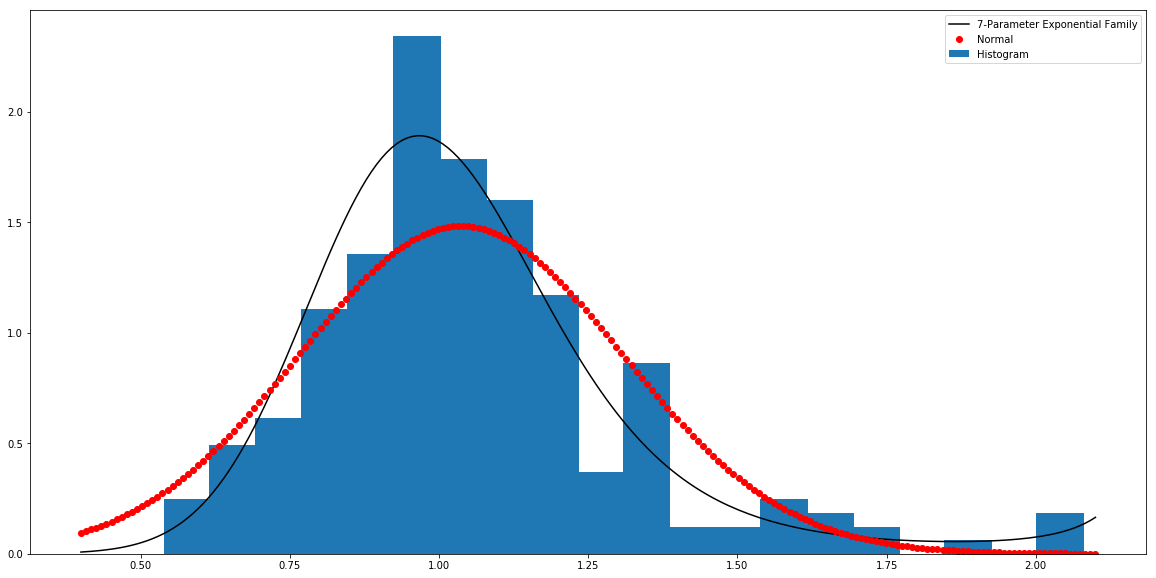

In [21]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot((np.linspace(0.4,2.1, 200)), pdf_vals, '-k')
ax.plot((np.linspace(0.4,2.1, 200)), pdf_vals_2p, 'or')
ax.hist(gfr_data['gfr'], bins, width=0.08, density=True)
ax.legend(['7-Parameter Exponential Family', 'Normal', 'Histogram'])